# Import Libraries and Dataset

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from collections import defaultdict

import plotly.express as px
import plotly.graph_objects as go

import spacy
spacy = spacy.load('en_core_web_sm')
from nltk.corpus import stopwords
stop_en = stopwords.words('english')
from textblob import TextBlob

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [96]:
raw_df = pd.read_csv('train-balanced-sarcasm.csv')
raw_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


# EDA

## Extracting the relevant columns

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [4]:
raw_df.isnull().sum()
raw_df.dropna(inplace=True)

In [5]:
# filter out the sarcastic comments
sarcastic_comments = raw_df[raw_df['label'] == 1]

# filter out the non-sarcastic comments
n_sarcastic_comments = raw_df[raw_df['label'] == 0]

In [6]:
# sub reddit in sarcastic comments
sarcastic_comments['subreddit'].value_counts().head(10)

subreddit
AskReddit          26365
politics           23907
worldnews          16947
leagueoflegends    11407
pcmasterrace       10759
news               10193
funny               8099
pics                7823
todayilearned       7753
GlobalOffensive     7584
Name: count, dtype: int64

In [7]:
# sub reddit in non-sarcastic comments
n_sarcastic_comments['subreddit'].value_counts().head(10)

subreddit
AskReddit          39309
politics           15586
funny               9840
leagueoflegends     9627
worldnews           9428
pics                8329
pcmasterrace        8228
nfl                 6935
news                6698
nba                 6698
Name: count, dtype: int64

In [8]:
# percentage of sarcastic comments in each subreddit in descending order
percent = sarcastic_comments['subreddit'].value_counts() / raw_df['subreddit'].value_counts()
percent.sort_values(ascending=False, inplace=True)
percent.dropna(inplace=True)
percent

subreddit
0x10c               1.000000
helpmebuildapc      1.000000
LumiaLovers         1.000000
Luna_Lovewell       1.000000
M43                 1.000000
                      ...   
magicskyfairy       0.033333
pumparum            0.025641
ledootgeneration    0.022727
ACTrade             0.019608
friendsafari        0.014085
Name: count, Length: 8993, dtype: float64

In [9]:
# comments in each subreddit in descending order
comments_sub = raw_df['subreddit'].value_counts()
comments_sub.sort_values(ascending=False, inplace=True)

# filter out the subreddits with more than 5000 comments
comments_5000 = comments_sub[comments_sub > 5000]

# list of subreddits with more than 5000 comments
listcomments_5000 = comments_5000.index.tolist()


In [10]:
percent_5000 = percent[percent.index.isin(listcomments_5000)]
percent_5000 = percent_5000.reset_index()
percent_5000.columns = ['subreddit', 'percentage']
percent_5000


,subreddit,percentage
0,creepyPMs,0.784303
1,worldnews,0.642540
2,atheism,0.639555
3,TumblrInAction,0.609766
4,politics,0.605348
5,news,0.603457
6,technology,0.599965
7,pcmasterrace,0.566651
8,AdviceAnimals,0.560822
9,GlobalOffensive,0.552045


## Visualizing the data

In [11]:
# graph of the percentage of sarcastic comments in each subreddit with more than 5000 comments
fig = px.bar(percent_5000, x='subreddit', y='percentage', title='Percentage of Sarcastic Comments in Each Subreddit with More Than 5000 Comments')
# add labels above the bars
fig.update_traces(texttemplate='%{y:.2%}', textposition='outside')
fig.show()

In [13]:
# graph of the number of comments in each subreddit with more than 5000 comments
fig = px.bar(comments_5000, x=comments_5000.index, y=comments_5000.values, title='Number of Comments in Each Subreddit with More Than 5000 Comments')
# add x and y axis labels
fig.update_xaxes(title_text='Subreddit')
fig.update_yaxes(title_text='Number of Comments')
# add labels above the bars
fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.show()

In [14]:
# compare the the number of comments in each subreddit with percentage of sarcastic comments in each subreddit 
fig = go.Figure()
fig.add_trace(go.Bar(x=percent_5000['subreddit'], y=percent_5000['percentage'], 
                     texttemplate='%{y:.2%}', textposition='outside', 
                     name='Percentage of Sarcastic Comments'))

fig.add_trace(go.Bar(x=comments_5000.index, y=comments_5000.values, 
                     texttemplate='%{y}', textposition='outside', 
                     name='Number of Comments', yaxis='y2'))
fig.update_layout(
    title='Percentage of Sarcastic Comments in Each Subreddit with More Than 5000 Comments',
    xaxis=dict(title='Subreddit'),
    yaxis=dict(title='Percentage of Sarcastic Comments'),
    yaxis2=dict(title='Number of Comments', overlaying='y', side='right'),
    legend=dict(x=0.5, y=1, xanchor='auto', yanchor='auto')
)
fig.show()


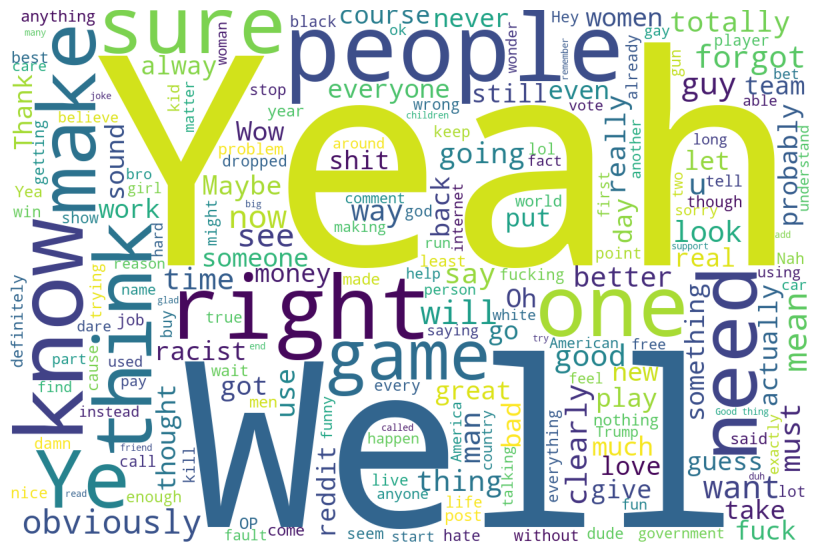

In [15]:
# word cloud of the sarcastic comments
wordcloud = WordCloud(width = 1200, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(' '.join(sarcastic_comments['comment']))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


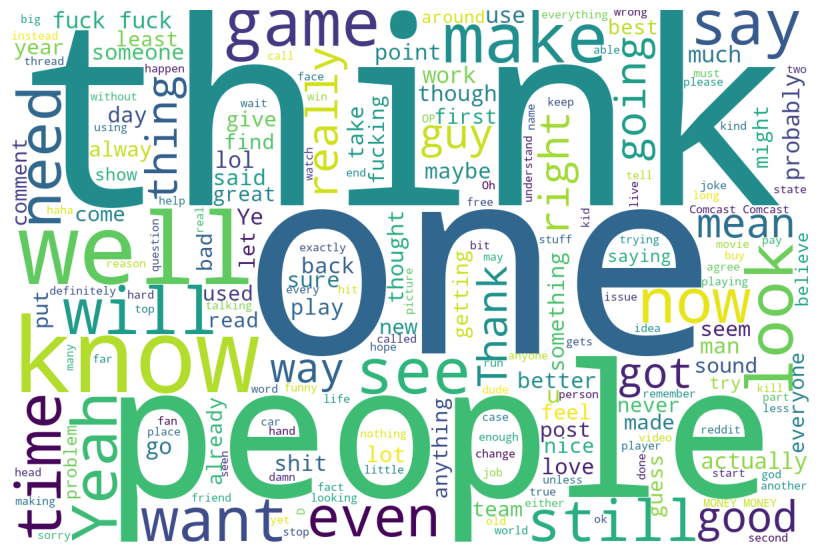

In [16]:
# word cloud of the non-sarcastic comments
wordcloud = WordCloud(width = 1200, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(' '.join(n_sarcastic_comments['comment']))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

In [17]:
sub_df = raw_df.groupby('author')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

C:\Users\annab\AppData\Local\Temp\ipykernel_68268\794367598.py:1: FutureWarning:

The provided callable <function mean at 0x000002B4EBEDDD00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.

C:\Users\annab\AppData\Local\Temp\ipykernel_68268\794367598.py:1: FutureWarning:

The provided callable <function sum at 0x000002B4EBEDC680> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



,size,mean,sum
author,,,
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mad-n-fla,318,0.500000,159
mindlessrabble,302,0.500000,151
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


In [18]:
# calculate the average score for sarcastic and non-sarcastic comments
sarcastic_comments['score'].mean().round(2), n_sarcastic_comments['score'].mean().round(2)


(6.4, 7.37)

In [19]:
# plot the average score for sarcastic and non-sarcastic comments in each subreddit
df = sarcastic_comments.groupby('subreddit')['score'].mean().round(2).sort_values(ascending=False).head(30).reset_index()
fig = px.bar(df, x='subreddit', y='score', title='Average Score for Sarcastic Comments in Each Subreddit')
fig.update_traces(texttemplate='%{y}', textposition='inside')
fig.show()


In [20]:
# plot the average score for non-sarcastic comments in each subreddit
df = n_sarcastic_comments.groupby('subreddit')['score'].mean().round(2).sort_values(ascending=False).head(30).reset_index()
fig = px.bar(df, x='subreddit', y='score', title='Average Score for Non-Sarcastic Comments in Each Subreddit')
fig.update_traces(texttemplate='%{y}', textposition='inside')
fig.show()

In [21]:
# plot the two lines: number of comments and number of sarcastic comments against time
df = raw_df.groupby('date')['label'].agg([np.size, np.sum])
df = df.reset_index()


fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=df['size'], mode='lines', 
                         line=dict(color='blue'), name='Number of Comments'))
fig.add_trace(go.Scatter(x=df['date'], y=df['sum'], mode='lines', 
                         line=dict(color='red'), name='Number of Sarcastic Comments'))
fig.update_layout(title='Number of Comments and Sarcastic Comments Against Time')
fig.show()

C:\Users\annab\AppData\Local\Temp\ipykernel_68268\2617056600.py:2: FutureWarning:

The provided callable <function sum at 0x000002B4EBEDC680> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



## Exploratory Using spaCY

In [11]:
spacy.max_length = 3000000  # Override the default allowed max length for a doc object

def process_comments(df, sample_size, random_state):
    df_sample = df.sample(sample_size, replace=False, random_state=random_state)
    df_sample['comment'] = df_sample['comment'].astype(str).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_en)]))
    text_list = df_sample['comment'].tolist()
    text = " ".join(text_list)
    doc = spacy(text)
    return doc

sarcasm_doc = process_comments(sarcastic_comments, 50000, 42)
non_sarcasm_doc = process_comments(n_sarcastic_comments, 50000, 42)

### Exclemation Mark and Question Mark Analysis

In [12]:
def count_character_type(str):
    excla = 0
    quest = 0
    for i in range(0, len(str)):
        ch = str[i]
        if ch == "!":
            excla+=1
        elif ch == "?":
            quest+=1
        
    return excla, quest

excl_sarcasm, quest_sarcasm = count_character_type(str(sarcasm_doc))
excl_non, quest_non = count_character_type(str(non_sarcasm_doc))

# plot the number of exclamation and question marks in sarcastic and non-sarcastic comments
fig = go.Figure()
fig.add_trace(go.Bar(x=['Number of Exclamation Marks', 'Number of Question Marks'], y=[excl_sarcasm, quest_sarcasm],
                        name='Sarcastic Comments'))
fig.add_trace(go.Bar(x=['Number of Exclamation Marks', 'Number of Question Marks'], y=[excl_non, quest_non],
                        name='Non-Sarcastic Comments'))
fig.update_layout(title='Number of Exclamation and Question Marks in Sarcastic and Non-Sarcastic Comments')
fig.show()

However, we already know that AskReddit is mostly about questions, so we eliminate this subreddit from the dataset and search again.

In [13]:
# eliminate AskReddit
sarcastic_nAR = sarcastic_comments[sarcastic_comments['subreddit'] != 'AskReddit']
n_sarcastic_nAR = n_sarcastic_comments[n_sarcastic_comments['subreddit'] != 'AskReddit']

sarcasm_nAR = process_comments(sarcastic_nAR, 50000, 42)
non_sarcasm_nAR = process_comments(n_sarcastic_nAR, 50000, 42)

In [14]:
excl_sarcasm, quest_sarcasm = count_character_type(str(sarcasm_nAR))
excl_non, quest_non = count_character_type(str(non_sarcasm_nAR))

# plot the number of exclamation and question marks in sarcastic and non-sarcastic comments
fig = go.Figure()
fig.add_trace(go.Bar(x=['Number of Exclamation Marks', 'Number of Question Marks'], y=[excl_sarcasm, quest_sarcasm],
                        name='Sarcastic Comments'))
fig.add_trace(go.Bar(x=['Number of Exclamation Marks', 'Number of Question Marks'], y=[excl_non, quest_non],
                        name='Non-Sarcastic Comments'))
fig.update_layout(title='Number of Exclamation and Question Marks in Sarcastic and Non-Sarcastic Comments')
fig.show()

In [55]:
# plot the number of capital letters in sarcastic and non-sarcastic comments
fig = go.Figure()
fig.add_trace(go.Bar(x=['Number of Capital Letters'], y=[len([word for word in str(sarcasm_doc) if word.isupper()])],
                        name='Sarcastic Comments'))
fig.add_trace(go.Bar(x=['Number of Capital Letters'], y=[len([word for word in str(non_sarcasm_doc) if word.isupper()])],
                        name='Non-Sarcastic Comments'))
fig.update_layout(title='Number of Capital Letters in Sarcastic and Non-Sarcastic Comments')
fig.show()

### 依赖性解析（Dependency Parsing）

In [15]:
# dependency parsing
def dependency_parsing(doc):
    dep = defaultdict(int)
    for token in doc:
        dep[token.dep_] += 1
    return dep

sarcasm_dep = dependency_parsing(sarcasm_doc)
non_sarcasm_dep = dependency_parsing(non_sarcasm_doc)

# plot the dependency parsing in sarcastic and non-sarcastic comments
fig = go.Figure()
fig.add_trace(go.Bar(x=list(sarcasm_dep.keys()), y=list(sarcasm_dep.values()), name='Sarcastic Comments'))
fig.add_trace(go.Bar(x=list(non_sarcasm_dep.keys()), y=list(non_sarcasm_dep.values()), name='Non-Sarcastic Comments'))
fig.update_layout(title='Dependency Parsing in Sarcastic and Non-Sarcastic Comments')
fig.show()

## Benchmark

In [ ]:
# train, test split by 80/20
X_train,X_test,Y_train,Y_test = train_test_split(raw_df['comment'].astype(str),raw_df['label'],random_state=0)

In [ ]:
# Create a new pipeline
lr_pipe = Pipeline([('tfidf', TfidfVectorizer()),('clf',  LogisticRegression(random_state = 0))])

# Fit the model
lr_pipe.fit(X_train, Y_train)

# Make predictions
Y_pred = lr_pipe.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.2f}")

e:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy: 0.69


## Merge Tokenized Data

In [96]:
# vectorize the parent_comment and comment columns
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_parent = vectorizer.fit_transform(raw_df['parent_comment'])
X_comment = vectorizer.fit_transform(raw_df['comment'])

In [78]:
def create_dummy_columns(data, column_name):
    dummy_columns = pd.get_dummies(data[column_name], prefix=column_name, drop_first=True)
    data = pd.concat([data, dummy_columns], axis=1)
    data = data.drop(columns=[column_name])
    return data

处理 subreddit 和 author 这两个特征的一种常见方法是使用独热编码（One-Hot Encoding）或者标签编码（Label Encoding）。但是，由于这两个特征可能有很多唯一值，直接编码可能会导致特征维度过高。因此，我们可以考虑以下策略：

频率编码：对于每个类别，计算其在数据集中出现的频率，然后用这个频率来替代原来的类别。这种方法可以保留一些类别的信息，而不会增加特征的维度。

目标编码：对于每个类别，计算其对应的目标变量（在这里是讽刺情绪）的平均值，然后用这个平均值来替代原来的类别。这种方法可以捕获类别和目标变量之间的关系，但可能会导致过拟合。

降维：如果类别数量仍然过多，可以考虑使用主成分分析（PCA）或其他降维方法来减少特征的维度。

In [97]:
# Frequency encoding for 'subreddit'
subreddit_freq = raw_df['subreddit'].value_counts() / len(raw_df)
raw_df['subreddit'] = raw_df['subreddit'].map(subreddit_freq)

# Frequency encoding for 'author'
author_freq = raw_df['author'].value_counts() / len(raw_df)
raw_df['author'] = raw_df['author'].map(author_freq)


In [98]:
# Concatenate all the features in the raw_df with the TF-IDF vectors of the comment to create a combined feature matrix.
import pandas as pd
from scipy.sparse import csr_matrix

# Convert the TF-IDF vectors into DataFrames
X_parent_df = pd.DataFrame.sparse.from_spmatrix(X_parent)
X_comment_df = pd.DataFrame.sparse.from_spmatrix(X_comment)

In [99]:
# use PCA to reduce the dimensionality of the TF-IDF vectors
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_parent_pca = pca.fit_transform(X_parent_df)
X_comment_pca = pca.fit_transform(X_comment_df)

# convert the PCA results into DataFrames
X_parent_pca_df = pd.DataFrame(X_parent_pca)
X_comment_pca_df = pd.DataFrame(X_comment_pca)

KeyboardInterrupt: 

In [ ]:
# Concatenate the DataFrames
X = pd.concat([raw_df, X_comment_pca_df], axis=1)

# Drop the 'parent_comment' and 'comment' columns
X = X.drop(columns=['comment', 'parent_comment'])

# drop the 'date' and 'created_utc' columns
X = X.drop(columns=['date', 'created_utc'])

# DROP NA
X.dropna(inplace=True)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='label'), X['label'], test_size=0.2, random_state=0)

# Convert all feature names to string
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Check for duplicate feature names
duplicate_columns = X_train.columns[X_train.columns.duplicated()]
if duplicate_columns.any():
    print(f"Duplicate columns found: {duplicate_columns}")

# Rename duplicate feature names
X_train.columns = [f"{x}_{i}" if x in duplicate_columns else x for i, x in enumerate(X_train.columns)]
X_test.columns = [f"{x}_{i}" if x in duplicate_columns else x for i, x in enumerate(X_test.columns)]


In [ ]:
# Create a pipeline
pipe = Pipeline([
    ('model', LogisticRegression())
])

# Fit the model
pipe.fit(X_train, y_train)

# Make predictions
y_pred = pipe.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Data Preprocessing

In [ ]:
# type of each column
raw_df.dtypes

In [ ]:
# normalize the date column
raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df['date'] = raw_df['date'].dt.normalize()
raw_df['created_utc'] = pd.to_datetime(raw_df['created_utc'])
raw_df['created_utc'] = raw_df['created_utc'].dt.normalize()
raw_df.dtypes

## Comments


In [78]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def process_comment(comment):
    tokens = word_tokenize(comment.lower())
    tokens = [word for word in tokens if word not in string.punctuation or word in ['!', '?']]
    # tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join the words back together
    return ' '.join(tokens)

raw_df['processed_comment'] = raw_df['comment'].astype(str).apply(process_comment)

In [79]:
def print_results(number):
    print(f"Original Comment: {raw_df['comment'][number]}")
    print(f"Processed Comment: {raw_df['processed_comment'][number]}")

print_results(10)

Original Comment: I think a significant amount would be against spending their tax dollars on other people.
Processed Comment: i think a significant amount would be against spending their tax dollar on other people


# Train the model

In [ ]:
raw_df1 = raw_df.sample(frac=1, random_state=42)

In [80]:
# train, test split by 80/20
X_train, X_test, Y_train, Y_test = train_test_split(raw_df['processed_comment'], raw_df['label'], test_size=0.2, random_state=0)

# using small sample size to speed up the process
X_train,X_test,Y_train,Y_test = train_test_split(raw_df1['processed_comment'].astype(str),raw_df1['label'], test_size=0.2,random_state=0)

## Logistic Regression

### Without Stop Words

In [91]:
lr_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))),('clf',  LogisticRegression(random_state = 0, solver='liblinear'))])
lr_clf.fit(X_train,Y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(random_state=0, solver='liblinear'))])

In [92]:
print(f"The accuracy on the training set is: {lr_clf.score(X_train,Y_train)}")
print(f"The accuracy on the test set is:  {lr_clf.score(X_test,Y_test)}")

The accuracy on the training set is: 0.8137325946627755
The accuracy on the test set is:  0.7242414649347566


In [93]:
# print n-grams coefficients
ngram = lr_clf.named_steps['tfidf']
feature_names = np.array(ngram.get_feature_names_out())
coefficients = lr_clf.named_steps['clf'].coef_[0]
coefficients_df = pd.DataFrame({'ngram': feature_names, 'coefficient': coefficients})
coefficients_df = coefficients_df.sort_values('coefficient', ascending=False)
coefficients_df.head(10)

,ngram,coefficient
1160937,obviously,10.958530
1927898,yes because,10.716589
351752,clearly,10.456361
208043,because,9.476986
1740211,totally,9.185634
1922188,yeah because,8.600723
502384,duh,7.739033
793109,how dare,6.797778
692532,good thing,6.506389
1482735,shitlord,6.453348


### With Stop Words

In [102]:
# remove the stop words
stop_words = list(set(stopwords.words('english')))
lr_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)),('clf',  LogisticRegression(random_state = 0, solver='liblinear'))])
lr_clf.fit(X_train,Y_train)

print(f"The accuracy on the training set is: {lr_clf.score(X_train,Y_train)}")
print(f"The accuracy on the test set is:  {lr_clf.score(X_test,Y_test)}")

The accuracy on the training set is: 0.8299631489130166
The accuracy on the test set is:  0.6650376423335279


### Combining the Parent Comment and the Comment

In [97]:
pc_df = raw_df

In [98]:
# combine the parent_comment and comment columns
pc_df['combined_comment'] = pc_df['parent_comment'] + ' ' + pc_df['comment'] 

# create a new column 'is_parent_comment', where if the comment is the same as the parent_comment, then it is 1, otherwise 0
pc_df['is_parent_comment'] = np.where(pc_df['combined_comment'] == pc_df['parent_comment'], 1, 0)

In [99]:
# in 'label' column, if the comment is the same as the parent_comment, then it is 0, otherwise do nothing
pc_df['label'] = np.where(pc_df['combined_comment'] == pc_df['parent_comment'], 0, pc_df['label'])

In [100]:
# train, test split by 80/20
X_train,X_test,Y_train,Y_test = train_test_split(pc_df['combined_comment'].astype(str),pc_df['label'], test_size=0.2,random_state=0)

lr_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))),('clf',  LogisticRegression(random_state = 0, solver='liblinear'))])
lr_clf.fit(X_train,Y_train)

print(f"The accuracy on the training set is: {lr_clf.score(X_train,Y_train)}")
print(f"The accuracy on the test set is:  {lr_clf.score(X_test,Y_test)}")

The accuracy on the training set is: 0.8146847871787896
The accuracy on the test set is:  0.6868909707863835


## XGBoost

In [39]:
# xgboost

xgb_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))),('clf',  XGBClassifier())])
xgb_clf.fit(X_train,Y_train)

print(f"The accuracy on the training set is: {xgb_clf.score(X_train,Y_train)}")
print(f"The accuracy on the test set is:  {xgb_clf.score(X_test,Y_test)}")

The accuracy on the training set is: 0.6961739465360274
The accuracy on the test set is:  0.6796856450923595


# Model Evaluation

In [26]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig = px.imshow(cm, labels=dict(x="Predicted", y="Actual", color="Count"), x=['Non-Sarcastic', 'Sarcastic'], y=['Non-Sarcastic', 'Sarcastic'])
fig.update_layout(title='Confusion Matrix')
fig.show()

In [27]:
# plot the ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', 
                         line=dict(color='blue'), name='ROC curve (area = %0.2f)' % roc_auc))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines',
                            line=dict(color='red', dash='dash'), name='Random'))
fig.update_layout(title='Receiver Operating Characteristic (ROC) Curve')
fig.update_xaxes(title_text='False Positive Rate')
fig.update_yaxes(title_text='True Positive Rate')
fig.show()

In [29]:
# plot the precision-recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

fig = go.Figure()
fig.add_trace(go.Scatter(x=recall, y=precision, mode='lines', 
                         line=dict(color='blue'), name='Precision-Recall curve'))
fig.update_layout(title='Precision-Recall Curve')
fig.update_xaxes(title_text='Recall')
fig.update_yaxes(title_text='Precision')
fig.show()
